<a href="https://colab.research.google.com/github/shusank8/DiffusionModels/blob/main/VisualizingLatentSpace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
print("Visualizing Auto Encoders hello world")

Visualizing Auto Encoders hello world


In [2]:
import torch
import torch.nn as nn

In [3]:
import torchvision
import torchvision.datasets as datasets
from torchvision.transforms import v2
from torch.utils.data import DataLoader

In [4]:
transforms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale =True),
    # v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [5]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms)


In [6]:
train_dataloader = DataLoader(mnist_trainset, batch_size=128, shuffle=True, num_workers=8)
test_dataloader = DataLoader(mnist_testset, batch_size=64, shuffle=True, num_workers=8)

In [7]:
len(train_dataloader), len(test_dataloader)

(469, 157)

In [8]:
for x in train_dataloader:
  print(x[0].shape,x[1].shape)
  break


torch.Size([128, 1, 28, 28]) torch.Size([128])


In [9]:
class VisualizingLatentSpace(nn.Module):

  def __init__(self, latentdim):
    super().__init__()
    self.latentdim = latentdim
    self.enoder = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=8, kernel_size=5, stride = 1, padding=1),
        nn.Conv2d(in_channels=8, out_channels=32, kernel_size=5, stride = 1),
        nn.AvgPool2d(kernel_size=2),
        nn.GroupNorm(32,32),
        nn.ReLU(),

        nn.Conv2d(in_channels=32, out_channels=16, kernel_size=5, stride = 1),
        nn.Conv2d(in_channels=16, out_channels=1, kernel_size=4, stride = 1),
        nn.AvgPool2d(kernel_size=(4,2)),
        nn.Sigmoid(),
    )

    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(in_channels=1, out_channels=16, kernel_size=(3,2)),
        nn.ConvTranspose2d(in_channels=16, out_channels=32, kernel_size=4,stride = 2),
        nn.GroupNorm(32,32),
        nn.ReLU(),
        nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=4,stride = 2),
        nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=4),
        nn.GroupNorm(16,16),
        nn.ReLU(),
        nn.ConvTranspose2d(in_channels=16, out_channels=3, kernel_size=5),
        nn.ConvTranspose2d(in_channels=3, out_channels=1, kernel_size=4),
        nn.GroupNorm(1,1),
        nn.Sigmoid(),
    )

  def forward(self, x):
    enc = self.enoder(x)
    dec = self.decoder(enc)
    return [enc, dec]

  def generate(self, x):
    # enc = self.enoder(x)
    dec = self.decoder(x)
    return dec



In [21]:
# # Create a generator
# gen = torch.Generator()

# # Set the seed for reproducibility
# gen.manual_seed(42)

dim = 2
model = VisualizingLatentSpace(dim)
for param in model.parameters():
  if param.dim()>=2:
    torch.nn.init.xavier_uniform_(param)
lossfn = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

In [29]:
vis = []
for i in range(5):
  for iter, x in enumerate(train_dataloader):

    # for img, label in train_dataloader:
      img=x[0]
      label = x[1]
      enc, out = model(img)
      loss = lossfn(out, img)
      loss.backward()
      if iter%2==0:
        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        if iter%100==0:

          print(f"{i}-{len(train_dataloader)}-{iter}, {loss.item()}")
      if iter==len(train_dataloader)-2:
        vis.append((i, enc, label))

0-469-0, 0.05455279350280762
0-469-100, 0.054996635764837265
0-469-200, 0.05572827160358429
0-469-300, 0.05589595064520836
0-469-400, 0.05583232641220093
1-469-0, 0.051022954285144806
1-469-100, 0.05462886020541191
1-469-200, 0.05391152575612068
1-469-300, 0.051066432148218155
1-469-400, 0.05471237003803253
2-469-0, 0.053969528526067734
2-469-100, 0.05187232792377472
2-469-200, 0.05121011659502983
2-469-300, 0.05330977961421013
2-469-400, 0.0500660315155983
3-469-0, 0.05066977068781853
3-469-100, 0.050624288618564606
3-469-200, 0.0516996867954731
3-469-300, 0.04936657473444939
3-469-400, 0.05354142561554909
4-469-0, 0.05015323683619499
4-469-100, 0.0523068904876709
4-469-200, 0.052872560918331146
4-469-300, 0.0509752556681633
4-469-400, 0.049665264785289764


In [30]:
len(vis)


5

In [31]:
# vis

In [32]:
vis[0][1].shape

torch.Size([128, 1, 1, 2])

In [33]:
vis[0][2].shape

torch.Size([128])

In [34]:
import torch
import plotly.express as px



for iteration, latents, labels in vis:
    # Convert latents from shape (B, 1, 1, 2) to (B, 2)
    # Detach and move to CPU if working with CUDA tensors
    latents_2d = latents.view(latents.size(0), 2).detach().cpu().numpy()
    # print(latents_2d)

    # Convert labels to numpy as well
    labels_np = labels.detach().cpu().numpy()

    # Create a Plotly Express scatter plot
    fig = px.scatter(
        x=latents_2d[:, 0],
        y=latents_2d[:, 1],
        color=labels_np,
        labels={'x': 'Dimension 1', 'y': 'Dimension 2', 'color': 'Labels'},
        title=f'Latent Space at Iteration {iteration}'
    )
    fig.update_traces(marker=dict(size=9))
    # Show interactive plot
    fig.show()


In [59]:
p = torch.tensor([0.21,0.16]).reshape(1,1,1,2)
i = model.generate(p)

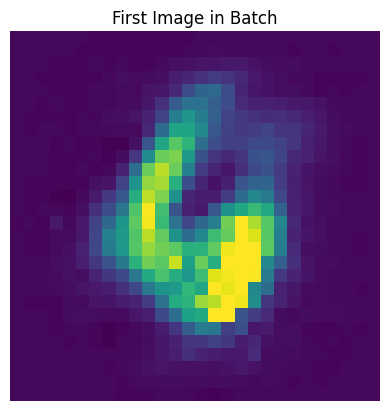

In [60]:
import torch
import matplotlib.pyplot as plt


# Select the first image in the batch
image_0 = i[0]  # shape is now [C, H, W]

#  If this is a multi-channel image (e.g., RGB), we need to permute
# from (C, H, W) to (H, W, C) to match what imshow expects:
image_0_perm = image_0.permute(1, 2, 0)  # now shape [H, W, C]

# Convert to a NumPy array
image_0_np = image_0_perm.detach().numpy()

# Step 4: Plot
plt.imshow(image_0_np)
plt.title("First Image in Batch")
plt.axis("off")
plt.show()
